# Data Structures - 
https://mlfinlab.readthedocs.io/en/latest/feature_engineering/data_structures.html#

## Structuring Candlesticks
The point of this section is to explore alternative ways of representing candlesticks that yield strong statistical properties.

The returns derived from volume and dollar bars tend to produce normal distributions when compared to their timeseries counterparts.

Below, I've created volume and dollar bars using BTC-USDT price data obtained from the
Binance exchange. Each cell looks at the serial correlation and distribution of returns of each type of standard bar.

Ideally, we'll use the candlesticks that elicit the best properties moving forward.

In [1]:

import collections

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import plotting

from trader import Binance

# I like to define these first, just so I don't have to later on
COLOURS = {
    "general": ["#3C8280", "#FAB131", "#ED5A3F"],
    "greens": ["#3C8280", "#7CB7B6", "#E5F1F0"],
    "reds": ["#ED5A3F", "#F27C5E", "#FBDED9"],
    "yellows": ["#FAB131", "#FBBC50", "#FDD898"],
}


def calculate_log_returns(series: pd.Series):
    return series.apply(np.log).diff().replace(np.nan, 0)

def plot_autocorrelation(
    series: pd.Series, ax: plt.Axes, xlim=50, ylim=0.1
) -> plt.Axes:

    plotting.autocorrelation_plot(series, ax=ax, color=COLOURS["reds"][1])
    ax.set_xlim([1, xlim])
    ax.set_ylim([-ylim, ylim])

    return ax


# Timeseries Bars (30 minutes per bar)
## Some Findings
1. Serial correlation seems small; however, the confidence bands make me hesitant.
2. Kurtosis seems rather high (at least visually). 

,open,high,low,close,volume,n_trades,log_returns
timestamp,,,,,,,
2017-08-17 04:29:59,4261.48,4280.56,4261.32,4261.45,11.308926,49,0.000000
2017-08-17 04:59:59,4280.00,4313.62,4267.99,4308.83,35.872083,122,0.011057
2017-08-17 05:29:59,4308.83,4328.69,4304.31,4320.00,21.048648,73,0.002589
2017-08-17 05:59:59,4320.00,4320.00,4291.37,4315.32,2.186268,29,-0.001084
2017-08-17 06:29:59,4330.29,4330.29,4309.37,4311.02,3.566277,14,-0.000997
...,...,...,...,...,...,...,...
2021-06-09 18:29:59,36536.51,36798.90,36251.01,36295.77,2577.070766,43508,-0.006611
2021-06-09 18:59:59,36295.77,36326.59,35816.00,35886.37,3646.824192,57807,-0.011344
2021-06-09 19:29:59,35886.37,36167.46,35650.16,36075.56,2666.925402,79836,0.005258


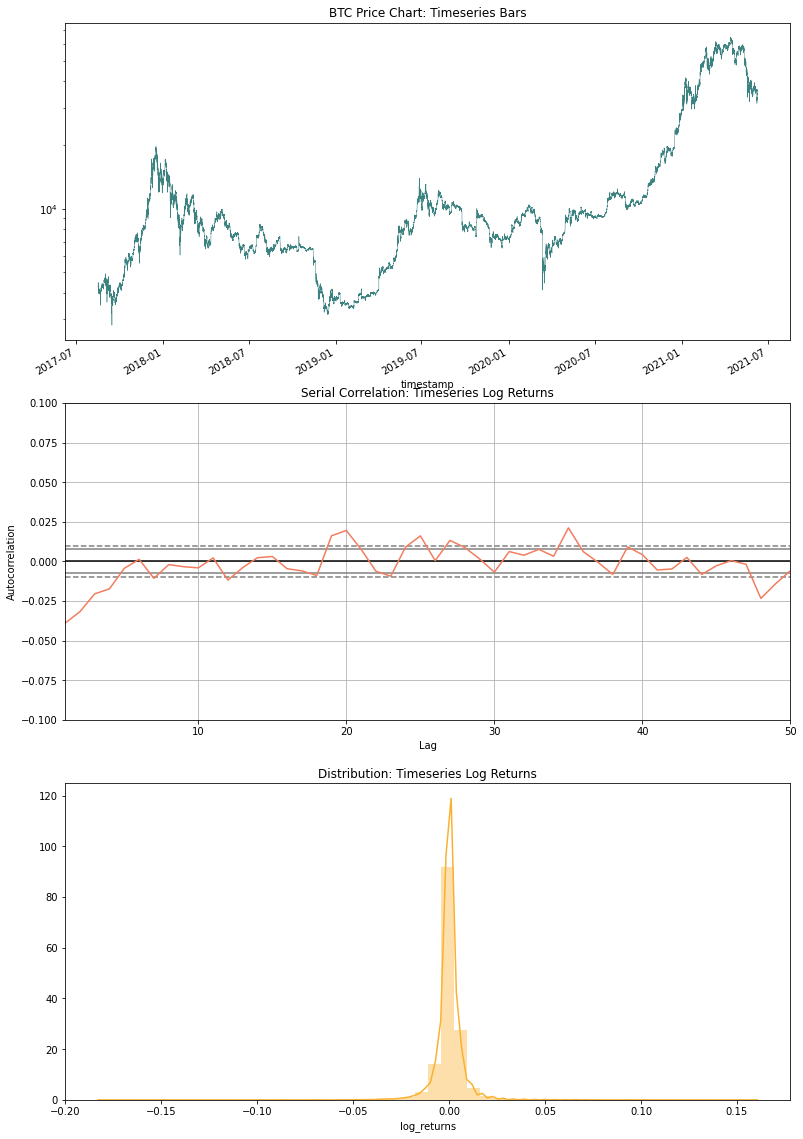

In [3]:
# Initialize an exchange
binance = Binance()
# Get bitcoin price data from binance
btc_usdt = binance.get_historical("BTCUSDT", interval="30m")

# Piecing together a dataframe with the price data
dataset = pd.DataFrame([candle.to_dict() for candle in btc_usdt]).set_index("timestamp")
dataset["log_returns"] = calculate_log_returns(dataset.close)

# Plot the candles nicely
fig, axes = plt.subplots(3, figsize=(13, 22))
ax = dataset["close"].plot(linewidth=0.5, ax=axes[0], color=COLOURS["greens"][0])
ax.set_yscale("log")
ax.set_title("BTC Price Chart: Timeseries Bars")
ax = plot_autocorrelation(dataset.log_returns, ax=axes[1])
ax.set_title("Serial Correlation: Timeseries Log Returns")
ax = sns.distplot(dataset.log_returns, ax=axes[2], color=COLOURS["yellows"][0])
ax.set_title("Distribution: Timeseries Log Returns")

dataset


# Volume Bars
Note the differences between the histograms!

This suggests that volume bars exhibit better statistical properties

Potential Problem!!
Because of how the trading volume of Bitcoin continues to increase, these bars tend to undersample the beginning of the dataset

Checkout [mlfinlab](https://mlfinlab.readthedocs.io/en/latest/feature_engineering/data_structures.html#volume-bars) for other implementations

,open,high,low,close,volume,n_trades,log_returns
timestamp,,,,,,,
2017-10-15 03:29:59,4261.48,5922.30,2817.00,5848.01,49810.916590,422783,0.000000
2017-11-11 03:59:59,5848.27,7770.02,5037.95,6730.00,49837.225766,342188,0.140474
2017-11-25 12:29:59,6730.02,8448.99,5325.01,8435.28,49807.570750,256428,0.225848
2017-12-03 02:59:59,8442.99,11300.03,8442.99,10936.94,49802.035455,224966,0.259723
2017-12-09 04:59:59,10936.40,17204.99,10500.00,15328.38,50111.055236,291585,0.337560
...,...,...,...,...,...,...,...
2021-06-07 23:59:59,36269.67,36777.47,33300.00,33552.79,52513.162421,1061073,-0.077862
2021-06-08 08:59:59,33556.96,34068.01,32123.00,32912.25,49818.483797,842189,-0.019275
2021-06-08 17:59:59,32912.20,33247.25,31000.00,32156.31,50334.804855,823637,-0.023236


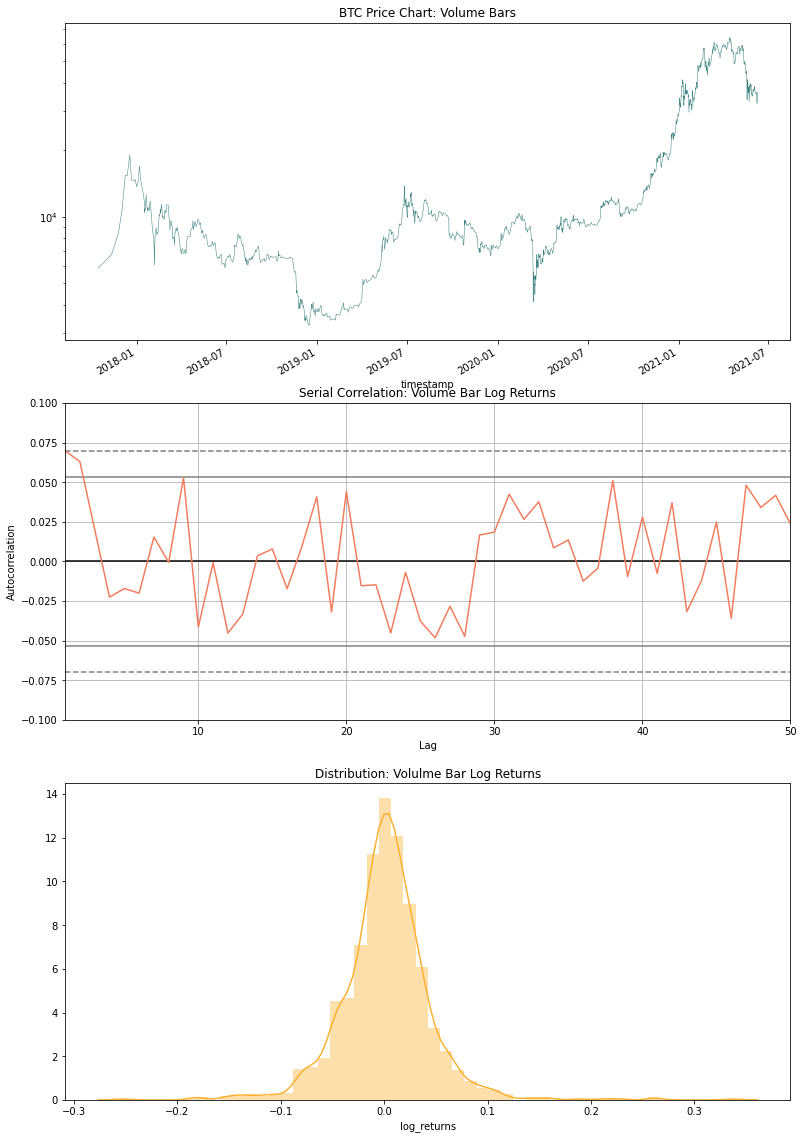

In [5]:
from trader import create_volume_bars, create_dollar_bars

# Average Daily Volume
# How much volume each candlestick will contain
daily_volume = dataset.resample("1D").agg({"volume": "sum"})
volume_amount = daily_volume.mean()[0]
# Volume Bar Basebar objects
volume_base = create_volume_bars(btc_usdt, volume_amount)
# Dataframe
volume_bars = pd.DataFrame([bar.to_dict() for bar in volume_base]).set_index("timestamp")
volume_bars["log_returns"] = calculate_log_returns(volume_bars.close)


fig, axes = plt.subplots(3, figsize=(13, 22))
ax = volume_bars["close"].plot(linewidth=0.5, ax=axes[0], color=COLOURS["greens"][0])
ax.set_yscale("log")
ax.set_title("BTC Price Chart: Volume Bars")
ax = plot_autocorrelation(volume_bars.log_returns, ax=axes[1])
ax.set_title("Serial Correlation: Volume Bar Log Returns")
ax = sns.distplot(volume_bars.log_returns, ax=axes[2], color=COLOURS["yellows"][0])
ax.set_title("Distribution: Volulme Bar Log Returns")

volume_bars


# Dollar Bars

Notes:
- I didn't use the suggested dollar bar theshold of 1/50 the average daily dollar volume. (Honestly I kind of just played around with the threshold value until I got something I liked, which is bad practice but honest...)
- Dollar bars still seem to have better statistical properties
- Confidence around serial correlation seems lower than what was seen with volume bars.

,open,high,low,close,volume,n_trades,log_returns
timestamp,,,,,,,
2017-10-01 21:29:59,4261.48,4939.19,2817.00,4353.99,38328.491235,306933,0.000000
2017-10-25 07:59:59,4344.99,6171.00,4110.00,5541.51,30110.531596,226524,0.241174
2017-11-08 01:59:59,5532.02,7590.25,5375.00,7275.00,22899.858568,172986,0.272177
2017-11-16 12:29:59,7274.99,7770.02,5325.01,7480.19,22257.124355,148312,0.027814
2017-11-21 14:29:59,7480.19,8319.99,7313.00,8240.00,20244.783446,98120,0.096742
...,...,...,...,...,...,...,...
2021-06-09 15:59:59,36393.53,36661.82,36270.77,36357.11,5958.229128,92978,-0.001003
2021-06-09 16:59:59,36356.42,36699.00,36070.05,36488.03,7745.256902,203236,0.003594
2021-06-09 17:59:59,36488.02,37000.00,36263.16,36536.51,6431.360713,148746,0.001328


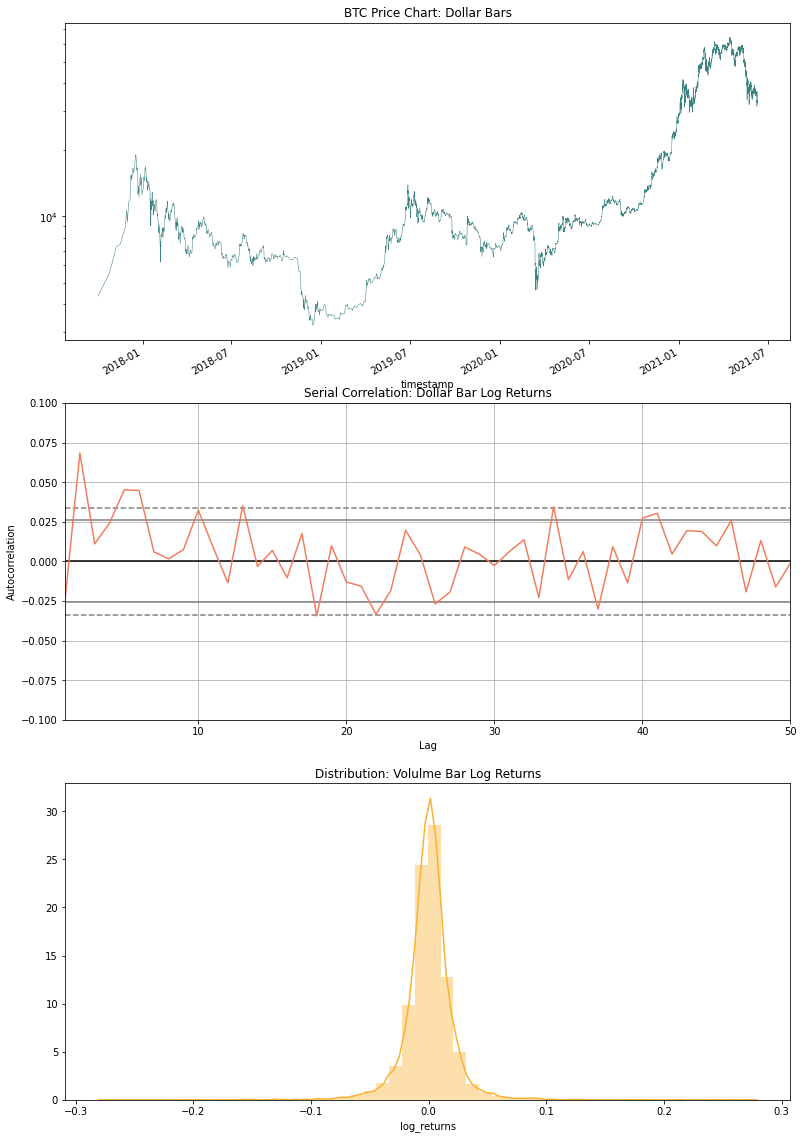

In [6]:
# How much dollar_volume each candlestick will contain
daily_volume = dataset.resample("1D").agg({"volume": "sum", "close": "last"})
daily_dollar = daily_volume["volume"] * daily_volume["close"]
daily_dollar_mean = daily_dollar.mean() / 5

# Dollar Bar Basebar objects
dollar_base = create_dollar_bars(btc_usdt, daily_dollar_mean)
# Dataframe
dollar_bars = pd.DataFrame([bar.to_dict() for bar in dollar_base]).set_index("timestamp")
dollar_bars["log_returns"] = calculate_log_returns(dollar_bars.close)

# Plotting
fig, axes = plt.subplots(3, figsize=(13, 22))
ax = dollar_bars["close"].plot(linewidth=0.5, ax=axes[0], color=COLOURS["greens"][0])
ax.set_yscale("log")
ax.set_title("BTC Price Chart: Dollar Bars")
ax = plot_autocorrelation(dollar_bars.log_returns, ax=axes[1])
ax.set_title("Serial Correlation: Dollar Bar Log Returns")
ax = sns.distplot(dollar_bars.log_returns, ax=axes[2], color=COLOURS["yellows"][0])
ax.set_title("Distribution: Volulme Bar Log Returns")

dollar_bars



# Short Summary
- Both volume and dollar bars have favorable statistical properties compared to their timeseries counterparts.
- These findings suggest we should avoid timeseries price data.